In [1]:
!pip install -qq diffusers datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
from huggingface_hub import notebook_login # Allows to download any pretrained model from huggingface

notebook_login()

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms

In [4]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-bedroom-256")
image_pipe.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.27.0",
  "_name_or_path": "google/ddpm-bedroom-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [6]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-bedroom-256") # gets scheduler used to train model

In [20]:
scheduler.set_timesteps(num_inference_steps=100)

In [21]:
scheduler.timesteps

tensor([990, 980, 970, 960, 950, 940, 930, 920, 910, 900, 890, 880, 870, 860,
        850, 840, 830, 820, 810, 800, 790, 780, 770, 760, 750, 740, 730, 720,
        710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580,
        570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470, 460, 450, 440,
        430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
        290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180, 170, 160,
        150, 140, 130, 120, 110, 100,  90,  80,  70,  60,  50,  40,  30,  20,
         10,   0])

In [22]:
noise = torch.randn(1, 3, 256, 256).to(device) # batch, color_channels, heught, width
for i, t in enumerate(scheduler.timesteps):
  model_input = scheduler.scale_model_input(noise, t)

  with torch.no_grad():
    noise_pred = image_pipe.unet(model_input, t)["sample"]

  scheduler_output = scheduler.step(noise_pred, t, noise)
  noise = scheduler_output.prev_sample


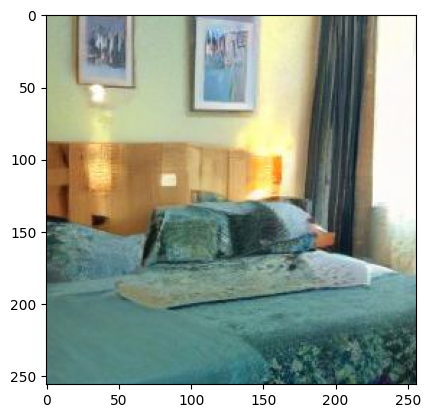

In [23]:
x0 = scheduler_output.pred_original_sample[0]
x0 = x0.permute(1, 2, 0)
plt.imshow(x0.cpu().clip(-1, 1) * 0.5 + 0.5)